# Playing with CityJSON and pyvista

This is a notebook with experiments and demonstration of what we can do with `pyvista` and `pymesh`

First we do some imports:

In [1]:
import json
import numpy as np
import pyvista as pv
from pymeshfix import MeshFix
import cityjson

Let's load some CityJSON file and have some minor boilerplate code:

In [2]:
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

models = {
    "DenHaag": "",
    "Helsinki": "/Users/liberostelios/Dropbox/CityJSON/Helsinki/CityGML_BUILDINGS_LOD2_NOTEXTURES_672496x2.json",
    "Vienna": "/Users/liberostelios/Dropbox/CityJSON/Vienna/Vienna_102081.json",
    "Montreal": "/Users/liberostelios/Dropbox/CityJSON/Montreal/VM05_2009.json"
}

filename = models["Montreal"]

with open(filename) as file:
    cm = json.load(file)

if "transform" in cm:
    s = cm["transform"]["scale"]
    t = cm["transform"]["translate"]
    verts = [[v[0] * s[0] + t[0], v[1] * s[1] + t[1], v[2] * s[2] + t[2]]
            for v in cm["vertices"]]
else:
    verts = cm["vertices"]

# mesh points
vertices = np.array(verts)

## Load a city object in `pyvista`

Pick a city object to play with:

In [3]:
# obj = "GUID_816CA7F9-6357-447D-96E3-C74C5E47AABF_2" # Den Haag
obj = list(cm["CityObjects"].keys())[0]
# obj = "UUID_LOD2_210138-f86f7351-7cad-4e8f-826f_2" # Vienna
# obj = "B-201391184551-8C37C51A0CFD" # Montreal building with open edge
# B-20139118400-95DC7A2E0FC0 Montreal

building = cm["CityObjects"][obj]

Loading and plotting the first geometry as a pure `pyvista` (no triangulation done). This sometimes doesn't work because VTK doesn't play well with complex polygons (anything over a quad):

In [4]:
dataset = cityjson.to_polydata(building["geometry"][0], vertices)
dataset = dataset.clean()
dataset.plot(show_edges=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Now let's load the object as a triangulated mesh (the triangulation is handled by us):

In [25]:
trimesh = cityjson.to_triangulated_polydata(building["geometry"][0], vertices).clean()
trimesh.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Basic analysis of the mesh

First, let's extract some feature edges:

In [6]:
trimesh.clean().extract_feature_edges().plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

We can plot the edges alongside the mesh itself:

In [7]:
p = pv.Plotter()

p.add_mesh(trimesh)
p.add_mesh(trimesh.extract_feature_edges(), color='black')

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's see if there are any open edges, so if the volume is watertight. Any open edges will be shown as red lines:

In [9]:
edges = trimesh.extract_feature_edges(boundary_edges=True,
                           feature_edges=False,
                           manifold_edges=False)

p = pv.Plotter()

p.add_mesh(trimesh, opacity=1.0)
if trimesh.n_open_edges:
    p.add_mesh(edges, color='red', line_width=10)

p.add_title(f"{obj} {'is watertight' if trimesh.n_open_edges == 0 else n_open_edges + ' open edges'}", 8)    

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

We can now voxelize the mesh. If this is not watertight, we have to force the library to avoid checking for surfaces and the result might be slightly incorrent:

In [23]:
clean = trimesh.clean()
voxel = pv.voxelize(clean, density=clean.length/100, check_surface=False)
voxel.plot(show_edges=True, text=f"[{obj}] Voxelized")

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's compare the voxelized volume against the actual one. This is an indication of the validity of the object:

In [26]:
print(f"Voxel: {voxel.volume}")
print(f"Actual: {clean.volume}")

Voxel: 16575.355766801047
Actual: 15060.606567299506


We can extract the voxels centers to produce a grid of points for the mesh. This is slightly inconsistent, as some points are in and some outside of the object. This can be further cleaned later by computing the implicit distance of the points:

In [12]:
p = pv.Plotter()

p.add_mesh(voxel, opacity=0.2, show_edges=True, color='yellow')
p.add_mesh(voxel.cell_centers(), color='black')
p.add_mesh(clean, color='grey')
p.add_mesh(pv.PolyData(np.mean(voxel.cell_centers().points, axis=0)), color='white')

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

The number of voxels is:

In [15]:
clean = trimesh.clean()
# clean.points -= np.mean(clean.points, axis=0)
voxel = pv.voxelize(clean, density=clean.length/100, check_surface=False)
voxel.n_cells

45917

## Compute the oriented bounding box

... or object-aligned bounding box, or minimum bounding rectangle etc.

We can compute this with a library we found on the web. The idea is that for buildings we can assume that an extruded 2D bounding box would work. So, let's do it in 2D first. This is the oriented bounding box:

In [18]:
from helpers.minimumBoundingBox import MinimumBoundingBox

obb_2d = MinimumBoundingBox([(p[0], p[1]) for p in dataset.clean().points])
obb_2d.area

1433.85213208308

Now let's extrude this with `pyvista`:

In [19]:
ground_z = np.min(dataset.clean().points[:, 2])
height = np.max(dataset.clean().points[:, 2]) - ground_z
box = np.array([[p[0], p[1], ground_z] for p in list(obb_2d.corner_points)])

obb = pv.PolyData(box).delaunay_2d()
pts = obb.points

t = np.mean(pts, axis=0)

# We need to move the points to the origin before extruding due to VTK's precision issues
obb.points = obb.points - t
obb = obb.extrude([0.0, 0.0, height])
obb.points = obb.points + t

Let's see how the oriented bounding box fits with the object itself:

In [20]:
p = pv.Plotter()

p.add_mesh(obb, opacity=0.3)
p.add_mesh(trimesh)

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Sometimes the extruded volume produces a weird volume, so we have to fix it first:

In [21]:
m = MeshFix(obb.clean().triangulate())
m.repair()
fixed_obb = m.mesh

fixed_obb.volume

3991.9041489147266

### Fully 3D oriented bounding box

There is a library to compute the bounding box in 3D, but it's not very reliable. This is a small test here:

In [27]:
from pyobb.obb import OBB

obb_full_3d = OBB.build_from_points(dataset.clean().points)

### 2D oriented bounding box from `shapely`

Similar to the previous library for 2D extrusion, we can compute the OBB using shapely. Let's extract a flattened version of the object and compute its *minimum rotated rectangle* (aka OBB):

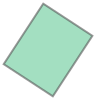

In [28]:
from cityjson import to_shapely

obb_2d = to_shapely(building["geometry"][0], vertices).minimum_rotated_rectangle
obb_2d

Now we can extrude (we wrote a function about this):

In [34]:
from geometry import extrude

ground_z = np.min(dataset.clean().points[:, 2])
roof_z = np.max(dataset.clean().points[:, 2])
obb = extrude(obb_2d, ground_z, roof_z)

# p = pv.Plotter()

# p.add_mesh(obb, show_edges=True, opacity=0.3)
# p.add_mesh(trimesh)

# p.show()

Let's compare the volumes:

In [35]:
m = MeshFix(obb.clean().triangulate())
m.repair()
fixed_obb = m.mesh

print(f"Volume: {clean.volume}")
print(f"OBB: {obb.volume}")

# p = pv.Plotter()

# p.add_mesh(obb.clean(), show_edges=True, opacity=0.3)
# p.add_mesh(trimesh)

# p.show()

Volume: 15060.606567299506
OBB: 23651.391192221894


## Compute shape metrics

This is a banch of 2D and 3D metrics that can be used to describe a building:

In [36]:
from shapely.geometry import Point, MultiPoint, Polygon
import math
from tqdm.notebook import trange, tqdm
import miniball

def create_grid_2d(shape, density):
    """Return the grid for a given polygon"""
    
    x_min, y_min, x_max, y_max = shape.bounds
    x = np.arange(x_min, x_max, density)
    y = np.arange(y_min, y_max, density)
    x, y = np.meshgrid(x, y)
    
    x = np.hstack(x)
    y = np.hstack(y)
    
    return [(x[i], y[i]) for i in range(len(x))]

def create_grid_3d(mesh, density, check_surface=False):
    """Returns the grid for a given mesh"""
    voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
    
    return voxel.cell_centers().points

def distance(x, y):
    """Returns the euclidean distance between two points"""
    
    return math.sqrt(sum([math.pow(x[c] - y[c], 2) for c in range(len(x))]))

def cohesion_2d(shape, grid=None, density=1):
    """Returns the cohesion index in 2D for a given polygon"""
    
    if grid is None:
        grid = create_grid(shape, density)
    
    if isinstance(grid, list):
        grid = MultiPoint(grid).intersection(shape)
    
    d = 0
    for pi in tqdm(grid.geoms):
        for pj in grid.geoms:
            if pi == pj:
                continue
            
            d += pi.distance(pj)

    n = len(grid.geoms)
    return 0.9054 * math.sqrt(shape.area / math.pi) / (1 / (n * (n - 1)) * d)

def cohesion_3d(mesh, density=1, check_surface=False):
    """Returns the cohesion index in 3D for a given mesh"""
    
    voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
    grid = voxel.cell_centers().points
    
    d = 0
    for pi in tqdm(grid):
        for pj in grid:
            d += distance(pi, pj)
    
    # TODO: Calculate the actual formula here
    return d

def proximity_2d(shape, density=1, grid=None):
    """Returns the proximity index in 2D for a given polygon"""
    
    if grid is None:
        grid = create_grid(shape, density)
    
    if isinstance(grid, list):
        grid = MultiPoint(grid).intersection(shape)
    
    centroid = shape.centroid
    
    return 2 / 3 * math.sqrt(shape.area / math.pi) / np.mean([centroid.distance(p) for p in grid])

def proximity_3d(mesh, grid=None, density=1, check_surface=False):
    """Returns the cohesion index in 3D for a given mesh"""
    
    if grid is None:
        voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
        grid = voxel.cell_centers().points
    
    centroid = np.mean(grid, axis=0)
    
    # TODO: Calculate the actual formula here
    return np.mean([distance(centroid, p) for p in grid])

def equal_volume_sphere(mesh, position=(0, 0, 0)):
    """Returns the sphere that has the same volume as the given mesh"""
    
    r = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
    
    return pv.Sphere(radius=r, center=position)

def exchange_2d(shape):
    """Returns the exchange index in 2D for a given polygon"""
    
    r = math.sqrt(shape.area / math.pi)
    
    eac = shape.centroid.buffer(r)
    
    return shape.intersection(eac).area / shape.area

def exchange_3d(mesh, evs=None, engine="igl"):
    """Returns the exhange index in 3D for a given mesh"""
    
    if evs is None:
        voxel = pv.voxelize(clean, density=0.25)
        grid = voxel.cell_centers().points

        centroid = np.mean(grid, axis=0)
        evs = equal_volume_sphere(mesh, centroid)
    
    pm_mesh = to_pymesh(mesh)
    pm_evs = to_pymesh(evs)
    
    inter = pymesh.boolean(pm_mesh, pm_evs, operation="intersection", engine=engine)
    
    return inter.volume / mesh.volume

def spin_2d(shape, grid=None, density=1):
    if grid is None:
        grid = create_grid_2d(shape, density)
    
    if isinstance(grid, list):
        grid = MultiPoint(grid).intersection(shape)
    
    centroid = shape.centroid
    
    return 0.5 * (shape.area / math.pi) / np.mean([math.pow(centroid.distance(p), 2) for p in grid])

def spin_3d(mesh, grid=None, density=1, check_surface=False):
    """Returns the cohesion index in 3D for a given mesh"""
    
    if grid is None:
        voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
        grid = voxel.cell_centers().points
    
    centroid = np.mean(grid, axis=0)
    
    # TODO: Calculate the actual formula here
    return np.mean([math.pow(distance(centroid, p), 2) for p in grid])

def perimeter_index(shape):
    return 2 * math.sqrt(math.pi * shape.area) / shape.length

def circumference_index_3d(mesh):
    return 4 * math.pi * math.pow(3 * mesh.volume / (4 * math.pi), 2 / 3) / mesh.area
    
def depth_2d(shape, grid=None, density=1):
    if grid is None:
        grid = create_grid_2d(shape, density)
    
    if isinstance(grid, list):
        grid = MultiPoint(grid).intersection(shape)
        
    return 3 * np.mean([p.distance(shape.boundary) for p in grid]) / math.sqrt(shape.area / math.pi)

def depth_3d(mesh, grid=None, density=1, check_surface=False):
    """Returns the cohesion index in 3D for a given mesh"""
    
    if grid is None:
        voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
        grid = voxel.cell_centers()
        
    dist = grid.compute_implicit_distance(mesh)
    
    # TODO: Calculate the actual formula here
    return 3 * np.mean(np.absolute(dist["implicit_distance"]))

from polylabel import polylabel

def largest_inscribed_circle(shape):
    """Returns the largest inscribed circle of a polygon in 2D"""

    centre, r = polylabel([list([list(c)[:2] for c in shape.boundary.coords])], with_distance=True)  # ([0.5, 0.5], 0.5)

    lic = Point(centre).buffer(r)
    
    return lic

def largest_inscribed_sphere(mesh, grid=None, density=1, check_surface=False):
    """Returns the largest inscribed sphere of a mesh in 3D"""
    
    if grid is None:
        voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
        grid = voxel.cell_centers()
        
    dist = grid.compute_implicit_distance(mesh)
    
    # The largest inscribed circle's radius is the largest (internal) distance,
    # hence the lowest value (as internal distance is negative)
    lis_radius = np.min(dist["implicit_distance"])
    lis_center = dist.points[np.where(dist["implicit_distance"] == lis_radius)][0]
    
    return pv.Sphere(center=lis_center, radius=abs(lis_radius))

def girth_2d(shape):
    """Return the girth index in 2D for a given polygon"""
    
    lic = largest_inscribed_circle(shape)
    
    # Compute the radius as half the bounding box width
    r = (lic.bounds[2] - lic.bounds[0]) / 2
    
    return r / math.sqrt(shape.area / math.pi)

def girth_3d(mesh, grid=None, density=1, check_surface=False):
    """Return the girth index in 3D for a given mesh"""
    
    lis = largest_inscribed_sphere(mesh,
                                   grid=grid,
                                   density=density,
                                   check_surface=check_surface)
    
    r = (lis.bounds[1] - lis.bounds[0]) / 2
    r_evs = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
    
    return r / r_evs

def range_2d(shape):
    """Returns the range index in 2D for a given polygon"""
    
    from helpers.smallestenclosingcircle import make_circle

    x, y, r = make_circle([c[:2] for c in  fp.boundary.coords])
    
    return math.sqrt(shape.area / math.pi) / r

def range_3d(mesh):
    """Returns the range index in 3D for a given mesh"""
    
    _, r2 = miniball.get_bounding_ball(mesh.points)
    
    r_scc = math.sqrt(r2)
    
    return math.pow(3 * mesh.volume / (4 * math.pi), 1/3) / r_scc

# cohesion_2d(Point(0,0).buffer(1.0), density=0.1)
# cohesion_3d(clean)
# proximity_2d(Point(0,0).buffer(1.0), 0.25)
# voxel = pv.voxelize(clean, density=0.25, check_surface=False)
# grid = voxel.cell_centers()
# dist = grid.compute_implicit_distance(clean)
# dist.active_scalar = "implicit_distance"
# dist.plot(scalars="implicit_distance")

# centroid = np.mean(grid, axis=0)

# exchange_3d(clean, evs)
# exchange_2d(Point(0, 0).buffer(25))

# spin_2d(Point(0,0).buffer(10.0), density=0.1)
# fp = to_shapely(building["geometry"][0], vertices)
# spin_2d(fp, density=0.1)
# girth_3d(pv.Sphere(radius=10.0), density=0.25)

# proximity_3d(evs, density=0.25) / proximity_3d(clean, density=0.25)

range_3d(clean)

0.547767731494774

This is our own implementation on creating a grid that wraps the surface of a mesh:

In [37]:
from helpers.geometry import surface_normal
from shapely.geometry import Polygon

def to_3d(points, normal, origin):
    """Translate local 2D coordinates to 3D"""
    
    x_axis, y_axis = axes_of_normal(normal)
  
    return (np.repeat([origin], len(points), axis=0)
        + np.matmul(points, [x_axis, y_axis]))    

def axes_of_normal(normal):
    """Returns an x-axis and y-axis on a plane of the given normal"""
    if normal[2] > 0.001 or normal[2] < -0.001:
        x_axis = [1, 0, -normal[0]/normal[2]];
    elif normal[1] > 0.001 or normal[1] < -0.001:
        x_axis = [1, -normal[0]/normal[1], 0];
    else:
        x_axis = [-normal[1] / normal[0], 1, 0];
    
    x_axis = x_axis / np.linalg.norm(x_axis)
    y_axis = np.cross(normal, x_axis)

    return x_axis, y_axis

def project_2d(points, normal):
    origin = points[0]

    x_axis, y_axis = axes_of_normal(normal)
     
    return [[np.dot(p - origin, x_axis), np.dot(p - origin, y_axis)] for p in points]

def create_surface_grid(mesh, density=1):
    """Create a 2-dimensional grid along the surface of a 3D mesh"""
    
    result = []
    
    sized = mesh.compute_cell_sizes()
    
    for i in range(mesh.n_cells):
        if not mesh.cell_type(i) in [5, 6, 7, 9, 10]:
            continue
        
        pts = mesh.cell_points(i)
        
        normal = surface_normal(pts)
        
        pts_2d = project_2d(pts, normal)
        poly_2d = Polygon(pts_2d)
        
        grid = create_grid_2d(poly_2d, density)
        grid = MultiPoint(grid).intersection(poly_2d)
        
        if grid.is_empty:
            continue
        elif grid.geom_type == "Point":
            grid = np.array(grid.coords)
        else:
            grid = np.array([list(p.coords[0]) for p in grid.geoms])
        
        # TODO: Randomise the origin
        result.extend(list(to_3d(grid, normal, pts[0])))
            
    return result

n = [5.082294680441933e-16, 0.0, -1.0]
p = np.array([[0, 0], [1, 2], [2, 2]])
origin = [0, 0, 0]
np.matmul(p, np.repeat([n], 2, axis=0))
s_grid = pv.PolyData(create_surface_grid(clean, 0.5))

p = pv.Plotter()

p.add_mesh(clean, opacity=0.9)
# p.add_mesh(clean.extract_cells(82))
p.add_mesh(s_grid)

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Compute the minimum bounding sphere of the building:

In [38]:
import miniball
C, r2 = miniball.get_bounding_ball(clean.clean().points)

print(r2)
print(clean.bounds)

p = pv.Plotter()

p.add_mesh(clean)
# p.add_mesh(clean.extract_cells(82))
p.add_mesh(pv.Sphere(radius=math.sqrt(r2), center=C), opacity=0.2)

p.show()

782.1853542416237
[300835.267, 300879.736, 5041621.967, 5041675.073, 15.297, 31.792]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Compute the largest inscribed sphere. This is based on creating a grid of a certain density and then picking the interior point of the largest distance from the boundaries (after computing the implicit distance):

In [40]:
p = pv.Plotter()

p.add_mesh(clean, opacity=0.2)
p.add_mesh(largest_inscribed_sphere(clean, density=0.5))

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Playing with `pymesh`

Since `pyvista` is unreliable regarding boolean operations, this is how to convert to/from `pymesh` to do operations. `pymesh` is harder to install (see [here](https://pymesh.readthedocs.io/en/latest/installation.html)) but the result seems to be robust:

In [42]:
import pymesh

def to_pymesh(mesh):
    """Returns a pymesh from a pyvista PolyData"""
    v = mesh.points
    f = mesh.faces.reshape(-1, 4)[:, 1:]

    return pymesh.form_mesh(v, f)

def to_pyvista(mesh):
    """Return a PolyData from a pymesh"""
    v = mesh.vertices
    f = mesh.faces
    
    f = np.hstack([[len(f)] + list(f) for f in mesh.faces])
    
    return pv.PolyData(v, f, len(mesh.faces))

evs = equal_volume_sphere(clean)

clean_pm = to_pymesh(clean)
evs_pm = to_pymesh(evs)

In [47]:
inter = pymesh.boolean(clean_pm, evs_pm, operation="intersection", engine="igl")

In [44]:
p = pv.Plotter()

p.add_mesh(evs, opacity=0.2, color='yellow')
p.add_mesh(to_pyvista(inter), opacity=0.5, color='blue')

p.show()

ValueError: need at least one array to concatenate